# QPCR data analysis

* Berberine vs. control for LRX1 / EXT13
* CHX / NMM vs Control for LRX1 / EXT13
* control is UBC10
* Data by Colette

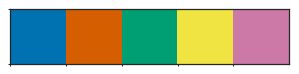

In [3]:
import sys
import os
from glob import glob
import re

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from IPython.display import display
pd.options.display.max_rows = 999

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex()[:3])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [4]:
nmm = pd.read_csv('./nmm_expression_data.csv', na_values='na')
nmm['is_housekeeping'] = nmm.gene == 'ubc10'
nmm['is_control_cond'] = nmm.cond == 'DMSO'
nmm['bio'] -= 1
nmm['tech'] -= 1
nmm.loc[nmm.ct > 30, 'ct'] = np.nan
nmm.head()

,gene,tissue,cond,bio,tech,ct,is_housekeeping,is_control_cond
0,ubc10,roots,DMSO,0,0,NaN,True,True
1,ubc10,roots,DMSO,1,0,17.96,True,True
2,ubc10,roots,DMSO,2,0,17.81,True,True
3,ubc10,roots,DMSO,0,1,17.20,True,True
4,ubc10,roots,DMSO,1,1,18.02,True,True


In [5]:
g = nmm.groupby('gene')
nmm_dct = []
for name, group in g:
    group['dct'] = group['ct'] - nmm.loc[nmm.is_housekeeping, 'ct'].values
    nmm_dct.append(group)
nmm_dct = pd.concat(nmm_dct)
nmm_dct.head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gene,tissue,cond,bio,tech,ct,is_housekeeping,is_control_cond,dct
126,ext13,roots,DMSO,0,0,19.63,False,True,NaN
127,ext13,roots,DMSO,1,0,20.66,False,True,2.70
128,ext13,roots,DMSO,2,0,20.50,False,True,2.69
129,ext13,roots,DMSO,0,1,21.34,False,True,4.14
130,ext13,roots,DMSO,1,1,21.67,False,True,3.65


In [6]:
g = nmm_dct.groupby(['gene', 'cond'])
nmm_ddct = []
for (gene_name, cond), group in g:
    group['ddct'] = - (group['dct'] - nmm_dct.loc[
        nmm_dct.is_control_cond & (nmm_dct.gene == gene_name),
        'dct'
    ].values)
    nmm_ddct.append(group)
nmm_ddct = pd.concat(nmm_ddct)
nmm_ddct.head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gene,tissue,cond,bio,tech,ct,is_housekeeping,is_control_cond,dct,ddct
126,ext13,roots,DMSO,0,0,19.63,False,True,NaN,NaN
127,ext13,roots,DMSO,1,0,20.66,False,True,2.70,-0.0
128,ext13,roots,DMSO,2,0,20.50,False,True,2.69,-0.0
129,ext13,roots,DMSO,0,1,21.34,False,True,4.14,-0.0
130,ext13,roots,DMSO,1,1,21.67,False,True,3.65,-0.0


/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ext13
lrx1


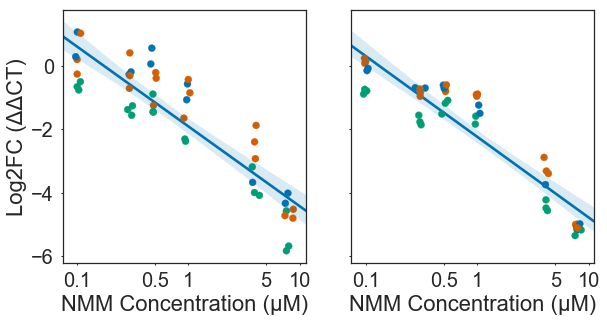

In [7]:
nmm_ddct_no_controls = nmm_ddct[~nmm_ddct.is_housekeeping & ~nmm_ddct.is_control_cond]
nmm_ddct_no_controls['nmm_conc'] = np.log10(nmm_ddct_no_controls.cond.str.extract('NMM_([\d\.]+)uM', expand=True).astype('f'))
nmm_ddct_no_controls['nmm_conc_jitter'] = (
    nmm_ddct_no_controls.nmm_conc +
    np.random.normal(scale=0.02, size=len(nmm_ddct_no_controls)))

xticks = [0.1, 0.5, 1, 5, 10]
fig, axes = plt.subplots(figsize=(9, 5), ncols=2, sharey=True)
for (gene, group), ax in zip(nmm_ddct_no_controls.groupby('gene', sort=False), axes):
    print(gene)
    ax.scatter(x='nmm_conc_jitter',
               y='ddct',
               c='bio',
               cmap=cmap,
               data=nmm_ddct_no_controls[nmm_ddct_no_controls.gene == gene])
    sns.regplot(x='nmm_conc',
                y='ddct',
                scatter=False,
                data=nmm_ddct_no_controls[nmm_ddct_no_controls.gene == gene],
                color='#0072b2',
                line_kws={'zorder': 0},
                ax=ax)
    ax.set_xlabel('NMM Concentration (μM)')
    ax.set_xticks(np.log10(xticks))
    ax.set_xticklabels(xticks)
axes[0].set_ylabel('Log2FC (ΔΔCT)')
axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig('ext13_lrx1_nmm_concentration_gradient.svg')
plt.show()

In [8]:
berb = pd.read_csv('./berberine_expression_data.csv')
berb['is_housekeeping'] = berb.gene == 'ubc10'
berb['is_control_cond'] = berb.cond == 'DMSO_50percent'
berb.head()

,gene,tissue,cond,bio,tech,ct,is_housekeeping,is_control_cond
0,ubc10,roots,DMSO_50percent,1,1,16.43,True,True
1,ubc10,roots,DMSO_50percent,2,1,16.65,True,True
2,ubc10,roots,DMSO_50percent,3,1,16.82,True,True
3,ubc10,roots,DMSO_50percent,1,2,16.36,True,True
4,ubc10,roots,DMSO_50percent,2,2,16.59,True,True


In [9]:
g = berb.groupby('gene')
berb_dct = []
for name, group in g:
    group['dct'] = group['ct'] - berb.loc[berb.is_housekeeping, 'ct'].values
    berb_dct.append(group)
berb_dct = pd.concat(berb_dct)
berb_dct.head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gene,tissue,cond,bio,tech,ct,is_housekeeping,is_control_cond,dct
72,ext13,roots,DMSO_50percent,1,1,19.69,False,True,3.26
73,ext13,roots,DMSO_50percent,2,1,19.67,False,True,3.02
74,ext13,roots,DMSO_50percent,3,1,19.80,False,True,2.98
75,ext13,roots,DMSO_50percent,1,2,19.67,False,True,3.31
76,ext13,roots,DMSO_50percent,2,2,19.56,False,True,2.97


In [10]:
g = berb_dct.groupby(['gene', 'cond'])
berb_ddct = []
for (gene_name, cond), group in g:
    group['ddct'] = - (group['dct'] - berb_dct.loc[
        berb_dct.is_control_cond & (berb_dct.gene == gene_name),
        'dct'
    ].values)
    berb_ddct.append(group)
berb_ddct = pd.concat(berb_ddct)
berb_ddct.head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gene,tissue,cond,bio,tech,ct,is_housekeeping,is_control_cond,dct,ddct
90,ext13,roots,Berberine_10uM,1,1,21.96,False,False,5.32,-2.06
91,ext13,roots,Berberine_10uM,2,1,20.81,False,False,4.40,-1.38
92,ext13,roots,Berberine_10uM,3,1,21.76,False,False,5.25,-2.27
93,ext13,roots,Berberine_10uM,1,2,22.03,False,False,5.52,-2.21
94,ext13,roots,Berberine_10uM,2,2,20.82,False,False,4.73,-1.76


In [11]:
set(berb.cond)

{'Berberine_10uM', 'Berberine_20uM', 'Berberine_5uM', 'DMSO_50percent'}

In [12]:
berb_ddct_no_controls = berb_ddct[~berb_ddct.is_housekeeping & ~berb_ddct.is_control_cond]
berb_ddct_no_controls['berberine_conc'] = np.log10(
    berb_ddct_no_controls.cond.str.extract('Berberine_(\d+)uM', expand=True).astype('f'))
berb_ddct_no_controls['berberine_conc_jitter'] = (
    berb_ddct_no_controls.berberine_conc +
    np.random.normal(scale=0.02, size=len(berb_ddct_no_controls)))

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ext13
lrx1


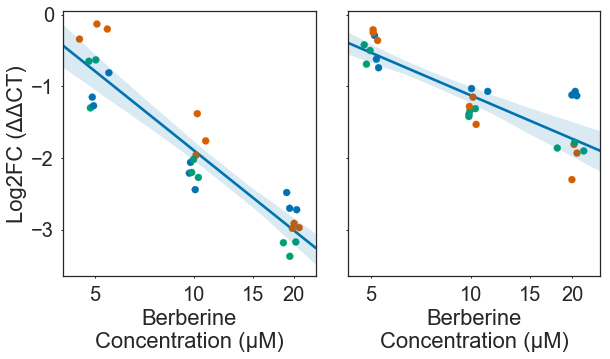

In [13]:
fig, axes = plt.subplots(figsize=(9, 5.5), ncols=2, sharey=True)
xticks = [5, 10, 15, 20]
for (gene, group), ax in zip(berb_ddct_no_controls.groupby('gene', sort=False), axes):
    print(gene)
    ax.scatter(x='berberine_conc_jitter',
               y='ddct',
               c='bio',
               cmap=cmap,
               data=berb_ddct_no_controls[berb_ddct_no_controls.gene == gene])
    sns.regplot(x='berberine_conc',
                y='ddct',
                scatter=False,
                data=berb_ddct_no_controls[berb_ddct_no_controls.gene == gene],
                color='#0072b2',
                line_kws={'zorder': 0},
                ax=ax)
    ax.set_xlabel('Berberine\nConcentration (μM)')
    ax.set_xticks(np.log10(xticks))
    ax.set_xticklabels(xticks)
axes[0].set_ylabel('Log2FC (ΔΔCT)')
axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig('ext13_lrx1_berberine_concentration_gradient.svg')
plt.show()

In [14]:
nmm_chx = pd.read_csv('./chx_nmm_expression_data.csv')
nmm_chx['is_housekeeping'] = nmm_chx.gene == 'ubc10'
nmm_chx['is_control_cond'] = nmm_chx.cond == 'etoh'
nmm_chx = nmm_chx[nmm_chx.cond != 'h2o']
nmm_chx.head()

,gene,tissue,cond,bio,tech,ct,is_housekeeping,is_control_cond
9,ubc10,roots,etoh,1,1,17.83,True,True
10,ubc10,roots,etoh,2,1,18.63,True,True
11,ubc10,roots,etoh,3,1,21.00,True,True
12,ubc10,roots,etoh,1,2,17.97,True,True
13,ubc10,roots,etoh,2,2,18.72,True,True


In [15]:
g = nmm_chx.groupby('gene')
nmm_chx_dct = []
for name, group in g:
    group['dct'] = group['ct'] - nmm_chx.loc[nmm_chx.is_housekeeping, 'ct'].values
    nmm_chx_dct.append(group)
nmm_chx_dct = pd.concat(nmm_chx_dct)
nmm_chx_dct.head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gene,tissue,cond,bio,tech,ct,is_housekeeping,is_control_cond,dct
99,ext13,roots,etoh,1,1,27.88,False,True,10.05
100,ext13,roots,etoh,2,1,28.65,False,True,10.02
101,ext13,roots,etoh,3,1,28.62,False,True,7.62
102,ext13,roots,etoh,1,2,27.78,False,True,9.81
103,ext13,roots,etoh,2,2,28.54,False,True,9.82


In [16]:
g = nmm_chx_dct.groupby(['gene', 'cond'])
nmm_chx_ddct = []
for (gene_name, cond), group in g:
    group['ddct'] = - (group['dct'] - nmm_chx_dct.loc[
        nmm_chx_dct.is_control_cond & (nmm_chx_dct.gene == gene_name),
        'dct'
    ].values)
    nmm_chx_ddct.append(group)
nmm_chx_ddct = pd.concat(nmm_chx_ddct)
nmm_chx_ddct.head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,gene,tissue,cond,bio,tech,ct,is_housekeeping,is_control_cond,dct,ddct
108,ext13,roots,chx_10uM,1,1,28.31,False,False,11.57,-1.52
109,ext13,roots,chx_10uM,2,1,30.84,False,False,11.30,-1.28
110,ext13,roots,chx_10uM,3,1,29.58,False,False,11.73,-4.11
111,ext13,roots,chx_10uM,1,2,28.82,False,False,12.73,-2.92
112,ext13,roots,chx_10uM,2,2,31.85,False,False,12.27,-2.45


In [17]:
nmm_chx_ddct_no_controls = nmm_chx_ddct[~nmm_chx_ddct.is_housekeeping & ~nmm_chx_ddct.is_control_cond]

ext13
lrx1


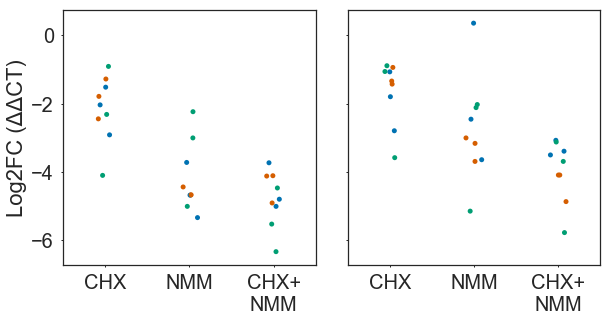

In [18]:
fig, axes = plt.subplots(figsize=(9, 5), ncols=2, sharey=True)
for (gene, group), ax in zip(nmm_chx_ddct_no_controls.groupby('gene', sort=False), axes):
    print(gene)
    sns.stripplot(x='cond',
                  hue='bio',
                  y='ddct',
                  palette=pal,
                  jitter=True,
                  order=['chx_10uM', 'nmm_8uM', 'chx_10uM_nmm_8uM'],
                  data=group,
                  ax=ax)
    ax.legend_.remove()
    ax.set_xticklabels(['CHX', 'NMM', 'CHX+\nNMM'])
    ax.set_xlabel('')
axes[0].set_ylabel('Log2FC (ΔΔCT)')
axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig('ext13_lrx1_nmm_chx.svg')
plt.show()

In [74]:
samples = ['etoh', 'chx', 'nmm', 'nmmchx']
samples = ['{}_{}'.format(s, i) for s in samples for i in range(1, 4)]
samples = {i: s for i, s in enumerate(samples)}
samples[12] = 'rt'
samples

{0: 'etoh_1',
 1: 'etoh_2',
 2: 'etoh_3',
 3: 'chx_1',
 4: 'chx_2',
 5: 'chx_3',
 6: 'nmm_1',
 7: 'nmm_2',
 8: 'nmm_3',
 9: 'nmmchx_1',
 10: 'nmmchx_2',
 11: 'nmmchx_3',
 12: 'rt'}

In [75]:
sample_map = [
    0, 0, 0, 8, 8, 8, 0, 0, 0, 8, 8, 8,
    1, 1, 1, 9, 9, 9, 1, 1, 1, 9, 9, 9,
    2, 2, 2, 10, 10, 10, 2, 2, 2, 10, 10, 10,
    3, 3, 3, 11, 11, 11, 3, 3, 3, 11, 11, 11,
    4, 4, 4, 12, 12, 12, 4, 4, 4, 12, 12, 12,
    5, 5, 5, 5, 5, 5,
    6, 6, 6, 6, 6, 6,
    7, 7, 7, 7, 7, 7,
]

gene_map = [
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
    0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
    0, 0, 0, 1, 1, 1,
    0, 0, 0, 1, 1, 1,
    0, 0, 0, 1, 1, 1,
]

In [86]:
ubc10_gtl1 = pd.read_csv(
    'CHX NMM random primed UBC10 GTL1 181718.csv',
    sep=',', skiprows=19, usecols=[0, 2, 4, 5])
ubc10_gtl1.columns = ['well', 'gene', 'cond', 'ct']
ubc10_gtl1['cond'] = [samples[i] for i in sample_map]
ubc10_gtl1['gene'] = [['ubc10', 'gtl1'][i] for i in gene_map]
ubc10_gtl1.head()

,well,gene,cond,ct
0,A01,ubc10,etoh_1,21.922125
1,A02,ubc10,etoh_1,22.471068
2,A03,ubc10,etoh_1,22.144565
3,A04,ubc10,nmm_3,22.857455
4,A05,ubc10,nmm_3,22.288498


In [87]:
rsl4_rhd6 = pd.read_csv(
    'CHX_NMM_random_primed_RSL4_RHD6_181718.csv',
    sep=',', skiprows=19, usecols=[0, 2, 4, 5])
rsl4_rhd6.columns = ['well', 'gene', 'cond', 'ct']
rsl4_rhd6['cond'] = [samples[i] for i in sample_map]
rsl4_rhd6['gene'] = [['rsl4', 'rhd6'][i] for i in gene_map]
rsl4_rhd6.head()

,well,gene,cond,ct
0,A01,rsl4,etoh_1,24.654065
1,A02,rsl4,etoh_1,24.907550
2,A03,rsl4,etoh_1,25.118467
3,A04,rsl4,nmm_3,31.892240
4,A05,rsl4,nmm_3,32.310569


In [105]:
df1_rsl2 = pd.read_csv(
    'CHX_NMM_random_primed_DF1_RSL2_181718.csv',
    sep=',', skiprows=19, usecols=[0, 2, 4, 5])
df1_rsl2.columns = ['well', 'gene', 'cond', 'ct']
df1_rsl2['cond'] = [samples[i] for i in sample_map]
df1_rsl2['gene'] = [['df1', 'rsl2'][i] for i in gene_map]
df1_rsl2.head()

,well,gene,cond,ct
0,A01,df1,etoh_1,24.478777
1,A02,df1,etoh_1,24.209535
2,A03,df1,etoh_1,24.228545
3,A04,df1,nmm_3,25.783712
4,A05,df1,nmm_3,25.979683


In [106]:
tf_chx = pd.concat([ubc10_gtl1, rsl4_rhd6, df1_rsl2])
tf_chx = tf_chx[tf_chx.cond != 'rt']
r = len(tf_chx) // 3
tf_chx['tech'] = np.repeat([1, 2, 3], repeats=r).reshape(-1, r).T.ravel()
tf_chx['bio'] = tf_chx['cond'].str.split('_', expand=True)[1].astype('i')
tf_chx['cond'] = tf_chx['cond'].str.split('_', expand=True)[0]
tf_chx.head()

,well,gene,cond,ct,tech,bio
0,A01,ubc10,etoh,21.922125,1,1
1,A02,ubc10,etoh,22.471068,2,1
2,A03,ubc10,etoh,22.144565,3,1
3,A04,ubc10,nmm,22.857455,1,3
4,A05,ubc10,nmm,22.288498,2,3


In [107]:
tf_chx['is_housekeeping'] = tf_chx.gene == 'ubc10'
tf_chx['is_control_cond'] = tf_chx.cond == 'etoh'
tf_chx.head()

,well,gene,cond,ct,tech,bio,is_housekeeping,is_control_cond
0,A01,ubc10,etoh,21.922125,1,1,True,True
1,A02,ubc10,etoh,22.471068,2,1,True,True
2,A03,ubc10,etoh,22.144565,3,1,True,True
3,A04,ubc10,nmm,22.857455,1,3,True,False
4,A05,ubc10,nmm,22.288498,2,3,True,False


In [108]:
g = tf_chx.groupby('gene')
tf_chx_dct = []
for name, group in g:
    group['dct'] = group['ct'] - tf_chx.loc[tf_chx.is_housekeeping, 'ct'].values
    tf_chx_dct.append(group)
tf_chx_dct = pd.concat(tf_chx_dct)
tf_chx_dct.head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,well,gene,cond,ct,tech,bio,is_housekeeping,is_control_cond,dct
0,A01,df1,etoh,24.478777,1,1,False,True,2.556652
1,A02,df1,etoh,24.209535,2,1,False,True,1.738467
2,A03,df1,etoh,24.228545,3,1,False,True,2.083980
3,A04,df1,nmm,25.783712,1,3,False,False,2.926257
4,A05,df1,nmm,25.979683,2,3,False,False,3.691184


In [126]:
g = tf_chx_dct.groupby(['gene', 'cond'])
pvals = {}
for (gene_name, cond), group in g:
    dct = group['dct']
    cntrl_dct = tf_chx_dct.loc[
        tf_chx_dct.is_control_cond & (tf_chx_dct.gene == gene_name),
        'dct'
    ]
    pvals[(gene_name, cond)] = stats.ttest_ind(dct, cntrl_dct)[1]
tf_chx_pvals = pd.Series(pvals).reset_index()
tf_chx_pvals.columns = ['gene', 'cond', 'pval']
tf_chx_pvals = tf_chx_pvals[(tf_chx_pvals.cond != 'etoh') &
                            (tf_chx_pvals.gene != 'ubc10')]
tf_chx_pvals

,gene,cond,pval
0,df1,chx,4.017593e-04
2,df1,nmm,4.417749e-05
3,df1,nmmchx,3.205341e-07
4,gtl1,chx,1.034608e-08
6,gtl1,nmm,1.497476e-08
7,gtl1,nmmchx,2.446554e-12
8,rhd6,chx,1.694789e-07
10,rhd6,nmm,6.654933e-10
11,rhd6,nmmchx,9.225355e-16
12,rsl2,chx,6.489413e-05


In [109]:
g = tf_chx_dct.groupby(['gene', 'cond'])
tf_chx_ddct = []
for (gene_name, cond), group in g:
    group['ddct'] = - (group['dct'] - tf_chx_dct.loc[
        tf_chx_dct.is_control_cond & (tf_chx_dct.gene == gene_name),
        'dct'
    ].values)
    tf_chx_ddct.append(group)
tf_chx_ddct = pd.concat(tf_chx_ddct)
tf_chx_ddct.head()

/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,well,gene,cond,ct,tech,bio,is_housekeeping,is_control_cond,dct,ddct
36,D01,df1,chx,23.974570,1,1,False,False,3.918712,-1.362059
37,D02,df1,chx,24.192772,2,1,False,False,3.038999,-1.300532
38,D03,df1,chx,23.933451,3,1,False,False,3.503239,-1.419259
48,E01,df1,chx,23.305290,1,2,False,False,3.192564,-1.042572
49,E02,df1,chx,23.097323,2,2,False,False,1.837019,0.032133


In [110]:
tf_chx_ddct_no_controls = tf_chx_ddct[~tf_chx_ddct.is_housekeeping & ~tf_chx_ddct.is_control_cond]

df1
gtl1
rhd6
rsl2
rsl4


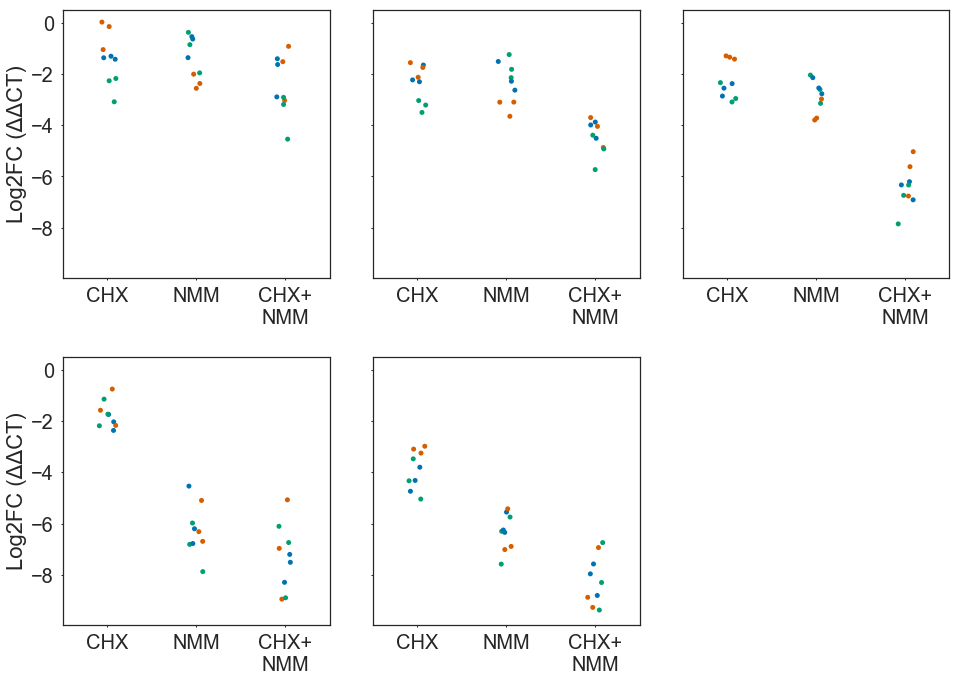

In [130]:
fig, axes = plt.subplots(figsize=(14, 10), ncols=3, nrows=2, sharey=True)
for (gene, group), ax in zip(tf_chx_ddct_no_controls.groupby('gene', sort=False), axes.ravel()):
    print(gene)
    sns.stripplot(x='cond',
                  hue='bio',
                  y='ddct',
                  palette=pal,
                  jitter=True,
                  order=['chx', 'nmm', 'nmmchx'],
                  data=group,
                  ax=ax)
    ax.legend_.remove()
    ax.set_xticklabels(['CHX', 'NMM', 'CHX+\nNMM'])
    ax.set_xlabel('')
for ax in axes.ravel():
    ax.set_ylabel('')
axes[0][0].set_ylabel('Log2FC (ΔΔCT)')
axes[1][0].set_ylabel('Log2FC (ΔΔCT)')
axes[-1][-1].set_axis_off()
plt.tight_layout()
plt.show()